# Loglinear Regression

Loglinear regressions treat the explanatory variable as an exponential function of the parameters, i.e.:

\begin{equation}
ln(y) = \mathbf{\beta \cdot x} + \epsilon
\end{equation}

With $\epsilon$ some noise term. The exogenous variabel $y$ has to be strictly positive.

Effectively, the algorithm fits an exponential curve, which seems like an extreme assumption about the data at first.

However, for sufficiently small coefficients, the exponential relationship is approximately linear. Empirically, loglinear and linear models seem to be about equally good at fitting line data when the data has approximately normal distribution, though they find notably different fits. The loglinear model even remains accurate in the interval of the exogenous variable not overlapping with the training data.

In the presence of outliers (which I modeled using a fat tailed noise distribution), the loglinear model has worse error when the error is averaged over many examples. However, in individual cases, the loglinear fit can actually be quite a bit better at outlier rejection than the linear fit.


Below, linear and loglinear regressions are fit to line data with t-distributed noise. The mean squared error and mean absolute error for train/test splits on the same range and on disconnected ranges are measured for different degrees of freedom of the noise distribution, ranging from highly fat tailed to normal. Lower degrees of freedom lead to fatter tails, high degrees of freedom result in normally distributed loss. It is running once for a relatively small dataset (N=5) and one for a moderately-sized dataset (N=100).

It's worth nothing that all the experiments below are in 1D.


### Motivation for Loglinear Regression:

Loglinear regression is a good choice when the effect of the exogenous variables is expected to be multiplicative, rather than additive. For example, when rates are in play where an exogenous variable modulates the impact of another exogenous variable.


#### Example
For example, assume that the number of customers $y$ at a bar are assumed to depend on the number of people living close by ($p \in [0,\infty)$) and whether the next day is a workday or not ($I_w \in [0,1]$). In that case, whether the next day is work day or not should not add a fixed number of customers across all bars. Rather, it makes it more likely that people will go to a bar, and so bars in areas with lots of people living close by should see a proportional increase in customers. 

The model should be:

\begin{equation}
y = c_p p c_w^{I_w}
\end{equation}

Where $c_p$ is the rate of someone close by going to a bar (at all) and $c_w$ is the rate increase on weekends. Taking the logarithm transforms this into a line equation:

\begin{equation}
\begin{array}{rl}
ln(y) &= ln(c_p) + ln(p) + ln(c_w) I_w \\
ln(\frac{y}{p}) &= ln(c_p) + ln(c_w) I_w
\end{array}
\end{equation}

Which gives a loglinear model. Less convincing would be:

\begin{equation}
y = e^{ap + b I_w + c}
\end{equation}

So then: 

\begin{equation}
ln(y) = c + ap + b I_w
\end{equation}

In that case the impact of the population parameter is modeled exponentially, which is a bit strange.

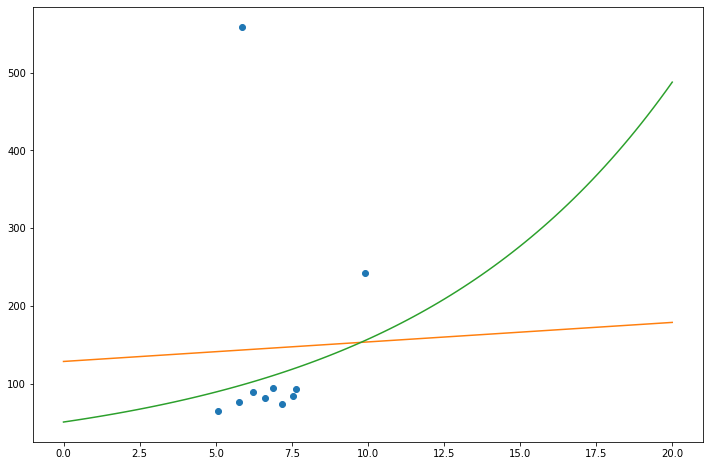

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

"""
Make Data, linear case, fat-tailed noise
"""

x_eval = np.linspace(0,20,100).reshape(-1,1)
x_train = (5,10)

def get_data(N,df=1,x_range=x_train):
    a = 10.3
    b = 10.25
    eps = 10.5

    x = np.sort(np.random.uniform(low=x_train[0],high=x_train[1],size=N))
    y = np.abs(a + b*x + eps*np.random.standard_t(df=df,size=N)) 
    
    return x.reshape(-1,1),y.reshape(-1,1)



class LogLinearRegression(LinearRegression):

    def fit(self,x,y):
        return super().fit(x,np.log(y))
        
    def predict(self,x):
        return np.exp(super().predict(x))
    
    
"""
Fit
"""

x,y = get_data(10)
linreg = LinearRegression().fit(x,y)
loglinreg = LogLinearRegression().fit(x,y)

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(x,y,'o')

ax1.plot(x_eval,linreg.predict(x_eval))
ax1.plot(x_eval,loglinreg.predict(x_eval))

df=1 done.000/100000
df=2 done.000/100000
df=3 done.000/100000
df=4 done.000/100000
df=5 done.000/100000
df=6 done.000/100000
df=7 done.000/100000
df=8 done.000/100000
df=9 done.000/100000
df=10 done.00/100000
df=11 done.00/100000
df=12 done.00/100000
df=13 done.00/100000
df=14 done.00/100000
df=15 done.00/100000
df=1 done.000/100000
df=2 done.000/100000
df=3 done.000/100000
df=4 done.000/100000
df=5 done.000/100000
df=6 done.000/100000
df=7 done.000/100000
df=8 done.000/100000
df=9 done.000/100000
df=10 done.00/100000
df=11 done.00/100000
df=12 done.00/100000
df=13 done.00/100000
df=14 done.00/100000
df=15 done.00/100000


Text(0.5, 0.98, 'Same Range, 5 Datapoints')

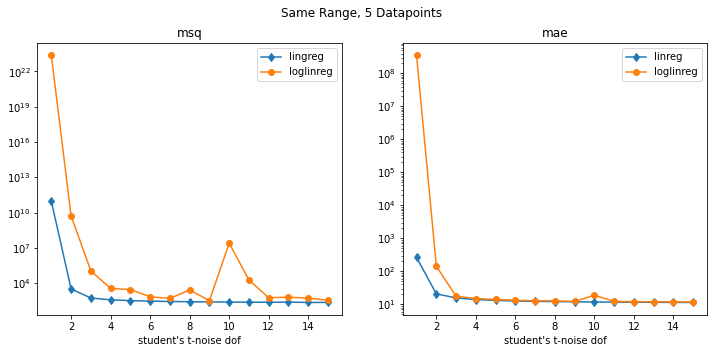

In [2]:
def get_error(model,x_range_train,x_range_test,df,n_datapoints_train):
    """
    train & test out of sample
    """
    N_TRIALS = 100000 # takes forever!!
    N_DATAPOINTS_TEST = 1000
    
    msq = []
    mae = []
    
    for i in range(N_TRIALS):
        if i% 1000 == 0:
            print("trials: %i/%i" % (i,N_TRIALS),end='\r')
        x_train,y_train = get_data(n_datapoints_train, df=df, x_range=x_range_train)
        x_test,y_test = get_data(N_DATAPOINTS_TEST, df=df, x_range=x_range_train)
        
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
        
        msq.append(mean_squared_error(y_pred,y_test))
        mae.append(mean_absolute_error(y_pred,y_test))
    
    print("df=%i done." % df)
    return np.mean(msq),np.mean(mae)


dfs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

linreg_errors_vs_df = np.array([get_error(LinearRegression(),x_range_train=(5,10),x_range_test=(5,10),df=df,n_datapoints_train=5) 
                       for df in dfs])

loglinreg_errors_vs_df = np.array([get_error(LogLinearRegression(),x_range_train=(5,10),x_range_test=(5,10),df=df,n_datapoints_train=5) 
                       for df in dfs])


fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.semilogy(dfs,linreg_errors_vs_df[:,0],'d-')
ax1.semilogy(dfs,loglinreg_errors_vs_df[:,0],'o-')
ax1.set_title('msq')
ax1.legend('lingreg,loglinreg'.split(','))
ax1.set_xlabel("student's t-noise dof")

ax2.semilogy(dfs,linreg_errors_vs_df[:,1],'d-')
ax2.semilogy(dfs,loglinreg_errors_vs_df[:,1],'o-')
ax2.set_title('mae')
ax2.legend('linreg,loglinreg'.split(','))
ax2.set_xlabel("student's t-noise dof")

plt.suptitle("Same Range, 5 Datapoints")

df=1 done.000/100000
df=2 done.000/100000
df=3 done.000/100000
df=4 done.000/100000
df=5 done.000/100000
df=6 done.000/100000
df=7 done.000/100000
df=8 done.000/100000
df=9 done.000/100000
df=10 done.00/100000
df=11 done.00/100000
df=12 done.00/100000
df=13 done.00/100000
df=14 done.00/100000
df=15 done.00/100000
df=1 done.000/100000
df=2 done.000/100000
df=3 done.000/100000
df=4 done.000/100000
df=5 done.000/100000
df=6 done.000/100000
df=7 done.000/100000
df=8 done.000/100000
df=9 done.000/100000
df=10 done.00/100000
df=11 done.00/100000
df=12 done.00/100000
df=13 done.00/100000
df=14 done.00/100000
df=15 done.00/100000


Text(0.5, 0.98, 'Out of Range, 5 Datapoints')

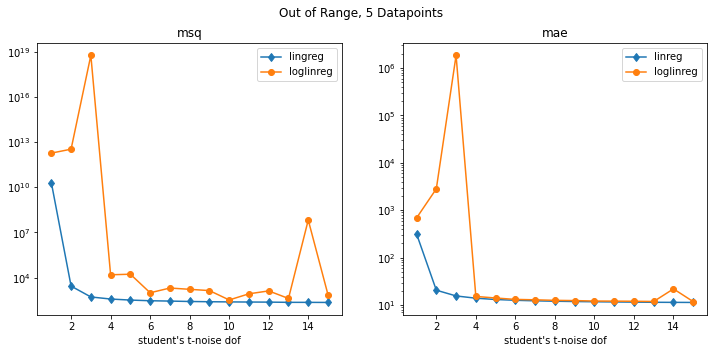

In [3]:
linreg_errors_vs_df = np.array([get_error(LinearRegression(),x_range_train=(5,10),x_range_test=(10,15),df=df,n_datapoints_train=5) 
                       for df in dfs])

loglinreg_errors_vs_df = np.array([get_error(LogLinearRegression(),x_range_train=(5,10),x_range_test=(10,15),df=df,n_datapoints_train=5) 
                       for df in dfs])


fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.semilogy(dfs,linreg_errors_vs_df[:,0],'d-')
ax1.semilogy(dfs,loglinreg_errors_vs_df[:,0],'o-')
ax1.set_title('msq')
ax1.legend('lingreg,loglinreg'.split(','))
ax1.set_xlabel("student's t-noise dof")

ax2.semilogy(dfs,linreg_errors_vs_df[:,1],'d-')
ax2.semilogy(dfs,loglinreg_errors_vs_df[:,1],'o-')
ax2.set_title('mae')
ax2.legend('linreg,loglinreg'.split(','))
ax2.set_xlabel("student's t-noise dof")

plt.suptitle("Out of Range, 5 Datapoints")

df=1 done.000/100000
df=2 done.000/100000
df=3 done.000/100000
df=4 done.000/100000
df=5 done.000/100000
df=6 done.000/100000
df=7 done.000/100000
df=8 done.000/100000
df=9 done.000/100000
df=10 done.00/100000
df=11 done.00/100000
df=12 done.00/100000
df=13 done.00/100000
df=14 done.00/100000
df=15 done.00/100000
df=1 done.000/100000
df=2 done.000/100000
df=3 done.000/100000
df=4 done.000/100000
df=5 done.000/100000
df=6 done.000/100000
df=7 done.000/100000
df=8 done.000/100000
df=9 done.000/100000
df=10 done.00/100000
df=11 done.00/100000
df=12 done.00/100000
df=13 done.00/100000
df=14 done.00/100000
df=15 done.00/100000


Text(0.5, 0.98, 'Same Range, 100 Datapoints')

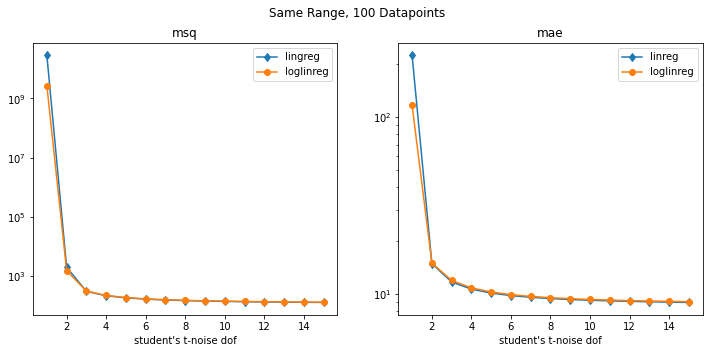

In [4]:
"""
Increase number of data points

"""

linreg_errors_vs_df = np.array([get_error(LinearRegression(),x_range_train=(5,10),x_range_test=(5,10),df=df,n_datapoints_train=100) 
                       for df in dfs])

loglinreg_errors_vs_df = np.array([get_error(LogLinearRegression(),x_range_train=(5,10),x_range_test=(5,10),df=df,n_datapoints_train=100) 
                       for df in dfs])


fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.semilogy(dfs,linreg_errors_vs_df[:,0],'d-')
ax1.semilogy(dfs,loglinreg_errors_vs_df[:,0],'o-')
ax1.set_title('msq')
ax1.legend('lingreg,loglinreg'.split(','))
ax1.set_xlabel("student's t-noise dof")

ax2.semilogy(dfs,linreg_errors_vs_df[:,1],'d-')
ax2.semilogy(dfs,loglinreg_errors_vs_df[:,1],'o-')
ax2.set_title('mae')
ax2.legend('linreg,loglinreg'.split(','))
ax2.set_xlabel("student's t-noise dof")

plt.suptitle("Same Range, 100 Datapoints")

df=1 done.000/100000
df=2 done.000/100000
df=3 done.000/100000
df=4 done.000/100000
df=5 done.000/100000
df=6 done.000/100000
df=7 done.000/100000
df=8 done.000/100000
df=9 done.000/100000
df=10 done.00/100000
df=11 done.00/100000
df=12 done.00/100000
df=13 done.00/100000
df=14 done.00/100000
df=15 done.00/100000
df=1 done.000/100000
df=2 done.000/100000
df=3 done.000/100000
df=4 done.000/100000
df=5 done.000/100000
df=6 done.000/100000
df=7 done.000/100000
df=8 done.000/100000
df=9 done.000/100000
df=10 done.00/100000
df=11 done.00/100000
df=12 done.00/100000
df=13 done.00/100000
df=14 done.00/100000
df=15 done.00/100000


Text(0.5, 0.98, 'Out of Range, 100 Datapoints')

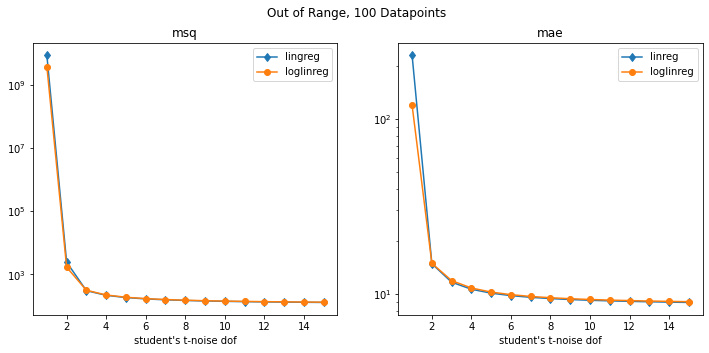

In [5]:
linreg_errors_vs_df = np.array([get_error(LinearRegression(),x_range_train=(5,10),x_range_test=(10,15),df=df,n_datapoints_train=100) 
                       for df in dfs])

loglinreg_errors_vs_df = np.array([get_error(LogLinearRegression(),x_range_train=(5,10),x_range_test=(10,15),df=df,n_datapoints_train=100) 
                       for df in dfs])


fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.semilogy(dfs,linreg_errors_vs_df[:,0],'d-')
ax1.semilogy(dfs,loglinreg_errors_vs_df[:,0],'o-')
ax1.set_title('msq')
ax1.legend('lingreg,loglinreg'.split(','))
ax1.set_xlabel("student's t-noise dof")

ax2.semilogy(dfs,linreg_errors_vs_df[:,1],'d-')
ax2.semilogy(dfs,loglinreg_errors_vs_df[:,1],'o-')
ax2.set_title('mae')
ax2.legend('linreg,loglinreg'.split(','))
ax2.set_xlabel("student's t-noise dof")

plt.suptitle("Out of Range, 100 Datapoints")